# List 12
## Hidden Markov models (HMM) - learning

### Knowledge & Skills:

 - HMM
 - Viterbi algorithm
 
### Remarks
 - Do not repeat yourself, check if the implementation of one task is also the implementation of others,
 - Do not copy your code, create functions and reuse them
 - Use env that will help you solve problems not create new ones in given task
 - [YouTube](https://www.youtube.com/watch?v=7tN5Ngf4iJE)
 - [PDF 1](http://www.cs.columbia.edu/4761/notes07/chapter4.3-HMM.pdf)
 - [PDF 2](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-047-computational-biology-fall-2015/lectures_slides/MIT6_047F15_Lecture05.pdf)
 - [PDF 3 - NLP](http://www.phontron.com/slides/nlp-programming-en-04-hmm.pdf)

In [1]:
!pip install numpy pandas networkx

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import math
import random
from copy import deepcopy
from sklearn import preprocessing
%matplotlib inline

In [3]:
class HMM:
    observations = pd.DataFrame()
    states = pd.DataFrame()
    Ptransition = pd.DataFrame()
    Pemission = pd.DataFrame()
    
    def normalize(self):
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        x = self.Ptransition.values
        x_scaled = scaler.fit_transform(x)
        self.Ptransition = pd.DataFrame(scaler.fit_transform(self.Ptransition.values),
                                        columns=self.Ptransition.columns,
                                        index=self.Ptransition.index)
        self.Pemission = pd.DataFrame(scaler.fit_transform(self.Pemission.values),
                                      columns=self.Pemission.columns,
                                      index=self.Pemission.index)
    
    def display(self):
        display(self.Ptransition)
        display(self.Pemission)

In [4]:
def getMarkovEdges(*Qs):
    edges = []
    for Q in Qs:
        for col in Q.columns:
            for idx in Q.index:
                edges += [(idx, col, Q.loc[idx,col])]
    return edges

In [5]:
def draw(hmm):
    G = nx.MultiDiGraph()

    G.add_nodes_from(['Start'], Type='Start')
    G.add_nodes_from(hmm.states['states'], Type='States')
    G.add_nodes_from(hmm.observations['observations'], Type='Observations')

    NodeStart = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Start']
    NodeStates = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'States']
    NodeObservations = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Observations']

    for s, t, w in getMarkovEdges(hmm.Pemission):
        G.add_edge(s, t, weight=w, label='{0:.3f}'.format(w), Type='Emission')
    EdgeEmission = [n for (n, ty) in nx.get_edge_attributes(G,'Type').items() if ty == 'Emission']

    edges = [('Start', idx, hmm.Ptransition.loc['Start', idx]) for idx in hmm.states['states'].values]
    for s, t, w in (edges + getMarkovEdges(hmm.Ptransition)):
        G.add_edge(s, t, weight=w, label='{0:.3f}'.format(w), Type='Normal')
    EdgeNormal = [n for (n, ty) in nx.get_edge_attributes(G,'Type').items() if ty == 'Normal']

    plt.figure(figsize=(15, 8))
    plt.axis('off')
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, font_color='w')
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='g', node_shape='p', nodelist=NodeStart)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_shape='s', node_color='#9999cc', nodelist=NodeStates)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='#000099', nodelist=NodeObservations)

    nx.draw_networkx_edges(G, pos, edgelist=EdgeEmission, edge_color='b', width=1)

    emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, label_pos=0.25,
                                 edge_labels=emit_edge_labels,
                                 arrowstyle='->', arrowsize=12)

In [6]:
def getOccurances(model, sequences, paths):
    transitionsPairs = [
        (stateA, stateB, 0) 
        for stateA, stateB
        in itertools.product(model.states['states'].values, model.states['states'].values)
    ]
    transitionsPairs += [('Start', state, 0) for state in model.states['states'].values]
    for path in paths:
        transitionsPairs += [(path[i], path[i + 1], 1) for i in range(len(path) - 1)]
        transitionsPairs += [('Start', path[0], 1)]
    transitionsPairs = pd.DataFrame(transitionsPairs, columns=['from', 'to', 'n'])
    transitions = transitionsPairs.groupby(['from', 'to']).sum()
    
    emissionsPairs = [
        (state, emission, 0) 
        for state, emission
        in itertools.product(model.states['states'].values, model.observations['observations'].values)
    ]
    for path, sequence in zip(paths, sequences):
        emissionsPairs += [(state, emission, 1) for state, emission in zip(path, sequence)]
    emissionsPairs = pd.DataFrame(emissionsPairs, columns=['state', 'observation', 'n'])
    emissions = emissionsPairs.groupby(['state', 'observation']).sum()

    return transitions, emissions

def learn(source, sequences, epsilon=0.1):
    model = deepcopy(source)
    
    transitions, emissions = getOccurances(model, [], [])
    delta = epsilon + 1
    
    while(delta > epsilon):
        paths = np.array([viterbi(s, model) for s in sequences])
        t, e = getOccurances(model, sequences, paths)
        transitions = transitions.add(t)
        emissions = emissions.add(e)
        delta = 0
        for stateA, stateB in itertools.product(*transitions.index.levels):
            n = transitions.loc[stateA, stateB].get('n')
            n = max(0.01, min(transitions.sum().get('n') - 0.01, n))
            newValue = math.log2(n)
            delta = max(delta, abs(model.Ptransition.loc[stateA, stateB] - newValue))
            model.Ptransition.loc[stateA, stateB] = newValue

        for state, emission in itertools.product(*emissions.index.levels):
            n = emissions.loc[state, emission].get('n')
            n = max(0.01, min(emissions.sum().get('n') - 0.01, n))
            newValue = math.log2(n)
            delta = max(delta, abs(model.Pemission.loc[state, emission] - newValue))
            model.Pemission.loc[state, emission] = newValue
    model.display()
    return model

Exercise 1
============

**Use already implemented HMM representation.**

In [7]:
model = HMM()
model.observations = pd.DataFrame(['sleeping', 'eating', 'pooping'], columns=['observations'])
model.states = pd.DataFrame(['Healthy', 'Sick'], columns=['states'])

model.Ptransition = pd.DataFrame([
    pd.Series({'Healthy': 0.75, 'Sick': 0.25}, name='Start'),
    pd.Series({'Healthy': 0.8, 'Sick': 0.2}, name='Healthy'),
    pd.Series({'Healthy': 0.4, 'Sick': 0.6}, name='Sick'),
], columns=model.states['states'].tolist())

model.Pemission = pd.DataFrame([
    pd.Series({'sleeping': 0.5, 'eating': 0.4, 'pooping': 0.1}, name='Healthy'),
    pd.Series({'sleeping': 0.1, 'eating': 0.3, 'pooping': 0.6}, name='Sick'),
], columns=model.observations['observations'].tolist())

model.display()

,Healthy,Sick
Start,0.75,0.25
Healthy,0.80,0.20
Sick,0.40,0.60


,sleeping,eating,pooping
Healthy,0.5,0.4,0.1
Sick,0.1,0.3,0.6


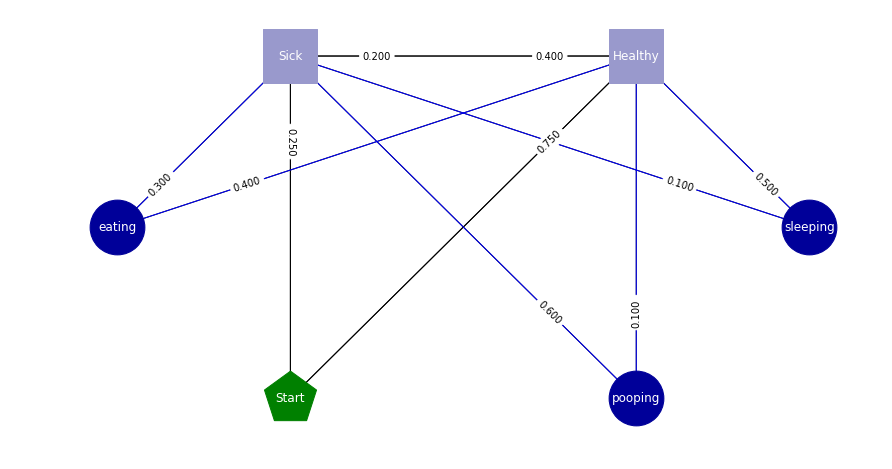

In [8]:
draw(model)

Exercise 2
============

**Use already implemented Viterbi algorithm.**

In [9]:
def viterbi(obs, model, show=False):
    states = model.states
    trans_p = model.Ptransition
    emit_p = model.Pemission
    V = [{}]
    for st in states['states'].values:
        V[0][st] = {
            "prob": trans_p.loc['Start', st] * emit_p.loc[st, obs[0]],
            "prev": None,
        }
    for t in range(1, len(obs)):
        V.append({})
        for st in states['states'].values:
            max_tr_prob = max(
                V[t-1][prev_st]["prob"] * trans_p.loc[prev_st, st]
                for prev_st in states['states'].values
            )
            for prev_st in states['states'].values:
                if V[t-1][prev_st]["prob"] * trans_p.loc[prev_st, st] == max_tr_prob:
                    max_prob = max_tr_prob * emit_p.loc[st, obs[t]]
                    V[t][st] = {"prob": max_prob, "prev": prev_st}
                    break
    if show:
        display(pd.DataFrame(V).applymap(lambda x: x['prob']).T)
    
    opt = []
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]
    if show:
        display(pd.DataFrame(opt, columns=['State sequence']).T)
        print('Max probability: {}'.format(max_prob))
    return opt

Exercise 3
============

**Prepare training data (sequences of symbols [AABBCC, ABCDE etc.], find existing dataset).**

In [10]:
sequences = (
    ('eating', 'eating', 'sleeping', 'sleeping', 'pooping', 'pooping'),
    ('pooping', 'sleeping', 'sleeping', 'sleeping', 'pooping', 'eating'),
    ('eating', 'eating', 'sleeping', 'pooping', 'pooping', 'eating'),
    ('sleeping', 'eating', 'sleeping', 'sleeping', 'eating', 'pooping'),
    ('pooping', 'eating', 'eating', 'sleeping', 'eating', 'sleeping'),
    ('sleeping', 'sleeping', 'sleeping', 'pooping', 'eating', 'pooping'),
)

Exercise 4
============

**Implement Viterbi learning:**
- iterate until changes > epsilon
- compute Viterbi paths for given data
- update transition/emission matrices according to frequencies from Viterbi paths

,Healthy,Sick
Start,7.499846,2.321928
Healthy,9.821774,3.169925
Sick,3.321928,2.584963


,sleeping,eating,pooping
Healthy,8.738092,8.523562,8.233620
Sick,2.807355,2.000000,3.169925


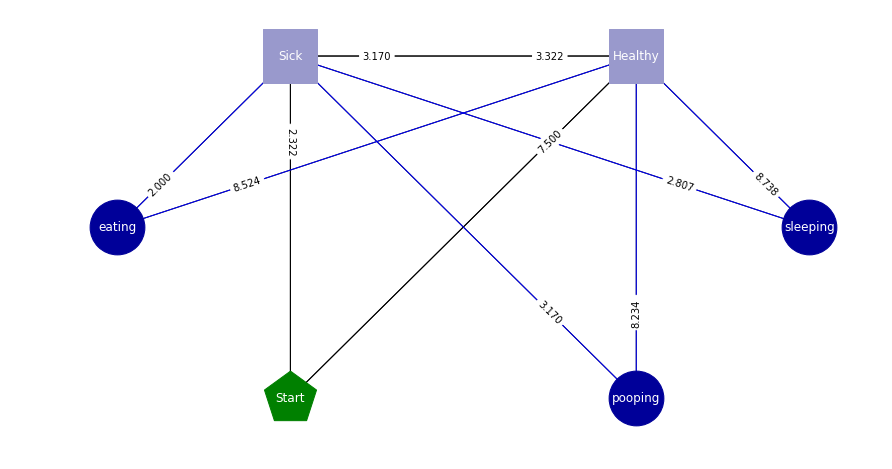

In [11]:
fittedModel = learn(model, sequences, 0.05)
draw(fittedModel)

Exercise 5
============

**Test trained model providing data with noise:**
- for symbols randomly change symbols and check if hidden states are same
- for existing data use train/test split

[['eating' 'eating' 'sleeping' 'sleeping' 'pooping' 'pooping']
 ['pooping' 'sleeping' 'sleeping' 'sleeping' 'pooping' 'eating']
 ['eating' 'eating' 'sleeping' 'pooping' 'pooping' 'eating']
 ['sleeping' 'eating' 'sleeping' 'sleeping' 'eating' 'pooping']
 ['pooping' 'eating' 'eating' 'sleeping' 'eating' 'sleeping']
 ['sleeping' 'sleeping' 'sleeping' 'pooping' 'eating' 'pooping']]
--------------------------------------
[['eating' 'eating' 'sleeping' 'sleeping' 'pooping' 'pooping']
 ['pooping' 'sleeping' 'sleeping' 'sleeping' 'pooping' 'eating']
 ['eating' 'eating' 'sleeping' 'pooping' 'pooping' 'eating']
 ['sleeping' 'eating' 'pooping' 'sleeping' 'eating' 'pooping']
 ['pooping' 'eating' 'eating' 'sleeping' 'eating' 'sleeping']
 ['sleeping' 'sleeping' 'sleeping' 'pooping' 'eating' 'pooping']]



Model without Noise:


,Healthy,Sick
Start,7.499846,2.321928
Healthy,9.821774,3.169925
Sick,3.321928,2.584963


,sleeping,eating,pooping
Healthy,8.738092,8.523562,8.233620
Sick,2.807355,2.000000,3.169925


Model with Noise:


,Healthy,Sick
Start,7.499846,2.321928
Healthy,9.821774,3.169925
Sick,3.321928,2.584963


,sleeping,eating,pooping
Healthy,8.629357,8.523562,8.375039
Sick,2.807355,2.000000,3.169925


Difference:


,Healthy,Sick
Start,0.0,0.0
Healthy,0.0,0.0
Sick,0.0,0.0


,sleeping,eating,pooping
Healthy,-0.108736,0.0,0.14142
Sick,0.000000,0.0,0.00000


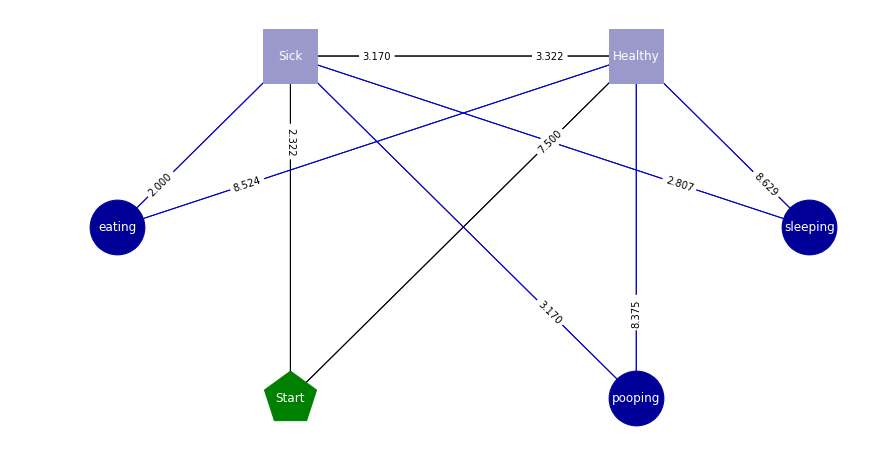

In [12]:
sequencesNoise = np.array(sequences)
for i, sequence in enumerate(sequencesNoise):
    changedObservation = random.choice(model.observations['observations'].values)
    sequencesNoise[i, random.randint(0, len(sequence) - 1)] = changedObservation
    
print(np.asarray(sequences))
print('--------------------------------------')
print(sequencesNoise)
print('\n\n')

print("Model without Noise:")
display(fittedModel.Ptransition)
display(fittedModel.Pemission)

print("Model with Noise:")
fittedModelNoise = learn(model, sequencesNoise, 0.05)

print("Difference:")
display(fittedModelNoise.Ptransition.subtract(fittedModel.Ptransition))
display(fittedModelNoise.Pemission.subtract(fittedModel.Pemission))

draw(fittedModelNoise)